# Assignment 06
#### Collaborators: Mauricio Bermudez, Alvaro Montoya Ruiz, Hriday Reddy Purma
#### Task: Multivariate Time Series Forecasting CNN model. Training and validation runs registry.

# Introduction

In this assignment, we are developing a forecasting model for a multivariate time series dataset. We will start by selecting a sequential dataset where at least two features are measured at equal time intervals. Our model will use past readings to predict a single output value at time t+1. To track our progress, we are integrating Weights & Biases (wandb) to log key training metrics, including MSE and MAE, as well as the network’s weights, biases, and gradients throughout the training process.

# 1. Importing Libraries and Setting the Device

We begin by importing libraries for numerical computations, plotting, neural network modeling with PyTorch, evaluation metrics, and wandb for experiment tracking. We then set the device based on CUDA availability.

In [1]:

import os
import wandb
import requests
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import requests_cache
import openmeteo_requests
from sklearn.metrics import mean_squared_error
from retry_requests import retry
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

# set repeatability
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)     # Set a random seed for CUDA operations.
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    
    # Ensure deterministic behavior for CUDA operations (note: If you are not concerned with reportable reproducibility, set deterministic to false, and benchmark to true - as it can choose faster algorithms).
    torch.backends.cudnn.deterministic = True  # Set cuDNN to deterministic mode - it will now only select algorithms that are known to be deterministic.
    torch.backends.cudnn.benchmark = False  # Disable cuDNN benchmarking - it may select the best algorithms for the hardware, but it doesn't guarantee deterministic results.   

Using device: cuda


# 2. Dataset :
This study aims to analyze historical weather data for Tampa, Florida (latitude: 27.9475, longitude: -82.4584), spanning from March 14, 1990, to March 28, 2025. The dataset retrieved from the Open-Meteo Archive API includes hourly historical weather data covering a period of over three decades. The selected meteorological parameters include: 

* Temperature at 2 meters (temperature_2m): Measures the air temperature near the surface, influencing climate studies and agricultural planning. 
* Precipitation (precipitation): Includes rain and snow measurements, crucial for understanding weather patterns, hydrology, and flood risks. 
* Mean Sea Level Pressure (pressure_msl): An indicator of large-scale weather patterns, such as storm systems and high-pressure zones. 
* Surface Pressure (surface_pressure): Helps analyze local weather variations and their impact on atmospheric stability. 
* Relative Humidity at 2 meters (relative_humidity_2m): Essential for studying moisture content in the air, impacting comfort levels and cloud formation. 
* Wind Speed at 10 meters (wind_speed_10m): Provides insights into wind patterns, which influence aviation, maritime activities, and renewable energy generation. 

In [2]:
# Setup Open-Meteo API client with cache and retry
def fetch_weather_data():
    cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
    retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
    openmeteo = openmeteo_requests.Client(session=retry_session)

    # Fetch weather data
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": 27.9475,
        "longitude": -82.4584,
        "start_date": "1990-03-14",
        "end_date": "2025-03-28",
        "hourly": [
            "temperature_2m", "precipitation", "pressure_msl",
            "surface_pressure", "relative_humidity_2m", "wind_speed_10m"
        ]
    }
    responses = openmeteo.weather_api(url, params=params)
    response = responses[0]  # Process first location

    # Extract hourly weather data
    hourly = response.Hourly()
    hourly_data = {
        "date": pd.date_range(
            start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
            end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
            freq=pd.Timedelta(seconds=hourly.Interval()),
            inclusive="left"
        ),
        "temperature": hourly.Variables(0).ValuesAsNumpy(),
        "humidity": hourly.Variables(4).ValuesAsNumpy(),
        "wind_speed": hourly.Variables(5).ValuesAsNumpy(),
        "precipitation": hourly.Variables(1).ValuesAsNumpy(),
        "pressure_msl": hourly.Variables(2).ValuesAsNumpy(),
        "surface_pressure": hourly.Variables(3).ValuesAsNumpy(),
    }

    return pd.DataFrame(data=hourly_data)


# 3. Preprocessing steps :

Train-Validation-Test Split: 

To maintain the temporal integrity of weather data, a time-series split is implemented. The dataset is divided into: 

* 70% Training Set: Used to learn patterns in historical weather data. 
* 15% Validation Set: Used to fine-tune hyperparameters and avoid overfitting. 
* 15% Test Set: Used for final model evaluation to measure generalization performance. 

Data Normalization: 

Applying Min-Max scaling to transform all features into a range of [0,1] based on the training set’s statistics. This strategy helps to make sure that all the features are on the same scale, preventing any single variable from dominating the model. 

Sequence Creation: 

Since time series models require sequential input, we create overlapping sequences of length seq_len that serve as training samples. The target variable is the temperature at the end of each sequence. This allows the model to learn temporal dependencies effectively. 

Data Loader Preparation 

To enable efficient model training, we convert the NumPy arrays into PyTorch tensors and use the DataLoader class to manage batching and shuffling. This ensures that data is fed into the model in an optimized manner for parallel processing. 

In [3]:
def time_series_split(df, train_ratio=0.7, val_ratio=0.15):
    """Splits the data into train, validation, and test sets."""
    n = len(df)
    train_end = int(n * train_ratio)
    val_end = train_end + int(n * val_ratio)

    train_data = df.iloc[:train_end]
    val_data = df.iloc[train_end:val_end]
    test_data = df.iloc[val_end:]

    return train_data, val_data, test_data

In [4]:
def create_sequences(data,seq_len):
        sequences, targets = [], []
        for i in range(len(data) - seq_len):
            sequences.append(data.iloc[i:i+seq_len].values)
            targets.append(data.iloc[i+seq_len]["temperature"])  # Predict temperature
        return np.array(sequences), np.array(targets)

In [5]:
def process_data(df, seq_len=4):
    """Processes data for training."""
    df = df.drop(columns=["date"])
    print(df.head)
    # Split data
    train_data, val_data, test_data = time_series_split(df)

    # Normalize each split separately using training set statistics
    scaler = MinMaxScaler()
    train_data = pd.DataFrame(scaler.fit_transform(train_data), columns=df.columns, index=train_data.index)
    val_data = pd.DataFrame(scaler.transform(val_data), columns=df.columns, index=val_data.index)
    test_data = pd.DataFrame(scaler.transform(test_data), columns=df.columns, index=test_data.index)


    X_train, y_train = create_sequences(train_data, seq_len)
    X_val, y_val = create_sequences(val_data,seq_len)
    X_test, y_test = create_sequences(test_data,seq_len)

    return X_train, y_train, X_val, y_val, X_test, y_test, scaler


In [6]:
# Read the API key from the text file
with open('API_KEY.txt', 'r') as file:
    wandb_api_key = file.read().strip()

if wandb_api_key:
    wandb.login(key=wandb_api_key)
else:
    raise ValueError("WANDB_API_KEY not found in API_KEY.txt!")

# Initialize wandb project
wandb.init(project="Assignment6", entity="usf-magma", config={
    "learning_rate": 0.0002,
    "dropout": 0.4,
    "batch_size": 64,
    "epochs": 10,
    "momentum": (0.9, 0.92),
    "weight_decay": 1e-5,
    "optimizer": "Adam",
    "criterion": "MSE",  # Changed to MAE
    "input_size": 1,
    "hidden_size": 64,
    "conv_out_channels" : 32,
    "seq_len":4
})

config = wandb.config

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Gonax133\_netrc
wandb: Currently logged in as: montoyaruiz (usf-magma) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [7]:
def prepare_dataloader(X, y, batch_size):
    """Create a DataLoader from given features and targets."""
    dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), 
                            torch.tensor(y, dtype=torch.float32).unsqueeze(1))
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [8]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, save_dir, device):
    """Train the model, log metrics, and save the best model based on validation loss."""

    model.to(device)  # Move model to device (CPU/GPU)
    train_losses, val_losses = [], []
    train_mae, val_mae = [], []
    best_loss = float("inf")  # Track best validation loss
    best_mae = float("inf")   # Track lowest validation MAE

    for epoch in range(num_epochs):
        model.train()
        running_loss, running_mae = 0.0, 0.0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move batch to GPU/CPU
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_mae += nn.functional.l1_loss(y_pred, y_batch).item()

        train_loss_epoch = running_loss / len(train_loader)
        train_mae_epoch = running_mae / len(train_loader)
        train_losses.append(train_loss_epoch)
        train_mae.append(train_mae_epoch)

        # Validation
        model.eval()
        val_loss, val_mae_epoch = 0.0, 0.0
        with torch.no_grad():
            for X_val_batch, y_val_batch in val_loader:
                X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)  # Move to GPU/CPU
                y_val_pred = model(X_val_batch)
                val_loss += criterion(y_val_pred, y_val_batch).item()
                val_mae_epoch += nn.functional.l1_loss(y_val_pred, y_val_batch).item()

        val_loss_epoch = val_loss / len(val_loader)
        val_mae_epoch = val_mae_epoch / len(val_loader)
        val_losses.append(val_loss_epoch)
        val_mae.append(val_mae_epoch)

        print(f"Epoch {epoch+1}/{num_epochs} -> Train Loss: {train_loss_epoch:.4f}, Val Loss: {val_loss_epoch:.4f}, Train MAE: {train_mae_epoch:.4f}, Val MAE: {val_mae_epoch:.4f}")

        # Log to wandb
        wandb.log({
            "Train Loss": train_loss_epoch,
            "Validation Loss": val_loss_epoch,
            "Train MAE": train_mae_epoch,
            "Validation MAE": val_mae_epoch
        })

        # Save the best model based on validation loss
        if val_loss_epoch < best_loss:
            best_loss = val_loss_epoch
            best_mae = val_mae_epoch  # Track best MAE
            model_save_path = os.path.join(save_dir, f"dual_rnn_best_epoch_{epoch+1}.pth")
            torch.save(model.state_dict(), model_save_path)
            wandb.save(model_save_path)
            print(f"Model saved: {model_save_path}")

            # Update wandb summary with best values
            wandb.run.summary["Best Validation Loss"] = best_loss
            wandb.run.summary["Best Validation MAE"] = best_mae

    # Plot Train Loss vs Validation Loss
    plt.figure(figsize=(10,5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Train Loss vs Validation Loss")
    plt.legend()
    plt.show()

    # Plot Train MAE vs Validation MAE
    plt.figure(figsize=(10,5))
    plt.plot(train_mae, label="Train MAE")
    plt.plot(val_mae, label="Validation MAE")
    plt.xlabel("Epochs")
    plt.ylabel("MAE")
    plt.title("Train MAE vs Validation MAE")
    plt.legend()
    plt.show()

    return model


In [9]:

def evaluate_model(model, test_loader, scaler, device):
    """Evaluate the model on the test set and plot Actual vs Prediction."""
    model.to(device)  # Ensure model is on the correct device
    model.eval()

    actuals, predictions = [], []

    with torch.no_grad():
        for X_test_batch, y_test_batch in test_loader:
            X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)  # Move to GPU/CPU
            y_test_pred = model(X_test_batch)

            # Convert tensors to NumPy
            y_test_pred_np = y_test_pred.cpu().numpy().reshape(-1, 1)
            y_test_actual_np = y_test_batch.cpu().numpy().reshape(-1, 1)

            # Apply inverse transform correctly
            # Create a matrix with the predicted values in the first column and zeros for others
            y_test_pred_full = np.zeros((y_test_pred_np.shape[0], scaler.scale_.shape[0]))  # Match feature dimension
            y_test_pred_full[:, 0] = y_test_pred_np.flatten()  # Fill temperature column with predictions

            y_test_actual_full = np.zeros((y_test_actual_np.shape[0], scaler.scale_.shape[0]))  # Same for actuals
            y_test_actual_full[:, 0] = y_test_actual_np.flatten()  # Fill temperature column with actuals

            # Apply inverse transform for both predicted and actual values
            y_test_pred_original = scaler.inverse_transform(y_test_pred_full)[:, 0]  # Get only temperature
            y_test_actual_original = scaler.inverse_transform(y_test_actual_full)[:, 0]  # Get only temperature

            actuals.extend(y_test_actual_original.tolist())
            predictions.extend(y_test_pred_original.tolist())

    # Compute final MSE
    test_mse = mean_squared_error(actuals, predictions)
    print(f"Test MSE: {test_mse:.4f}")

    # Print first 10 actual and predicted values
    print("First 10 Actual Values: ", actuals[:10])
    print("First 10 Predicted Values: ", predictions[:10])

    # Plot Actual vs Predicted Values
    plt.figure(figsize=(10, 5))
    plt.scatter(actuals, predictions, alpha=0.5, label="Predicted vs Actual")
    plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], color='red', linestyle='--', label="Perfect Prediction")
    plt.xlabel("Actual Temperature")
    plt.ylabel("Predicted Temperature")
    plt.title("Actual vs Predicted Temperature")
    plt.legend()
    plt.show()

    return test_mse

# 4. Model Achitecture 1D CNN :

The model architecture is designed as a 1D Convolutional Neural Network (CNN) to effectively capture temporal relationships in weather data. The CNN consists of two convolutional layers, each followed by ReLU activation and max pooling. The first convolutional layer has config.conv_out_channels filters with a kernel size of 3, processing the input time-series data while preserving local weather patterns. A max pooling operation reduces the sequence length by half, allowing the network to focus on dominant temporal features. The second convolutional layer doubles the number of filters, further refining feature extraction. Another max pooling operation reduces dimensionality, ensuring computational efficiency. 

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # First convolutional layer for 6 input features
        self.conv1 = nn.Conv1d(in_channels=6, out_channels=config.conv_out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=config.conv_out_channels, out_channels=config.conv_out_channels*2, kernel_size=3, padding=1)
        
        # Max pooling layer to reduce spatial dimensions
        self.pool = nn.MaxPool1d(kernel_size=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(config.conv_out_channels*2 * (config.seq_len // 4), config.hidden_size)
        self.fc2 = nn.Linear(config.hidden_size, 1)
        
        self.dropout = nn.Dropout(config.dropout)
    
    def forward(self, x):
        # Each feature corresponds to a separate channel in the input
        # x has shape [batch_size, seq_len, num_features] -> We need to permute it to [batch_size, num_features, seq_len]
        x = x.permute(0, 2, 1)  # [batch_size, 6, seq_len]
        
        # Apply convolutional layers
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        
        # Flatten the output for the fully connected layers
        x = x.view(x.size(0), -1)
        
        # Apply fully connected layers with dropout
        x = torch.tanh(self.fc1(x))
        x = self.dropout(x)
        prediction = self.fc2(x)
        
        return prediction


Using device: cuda


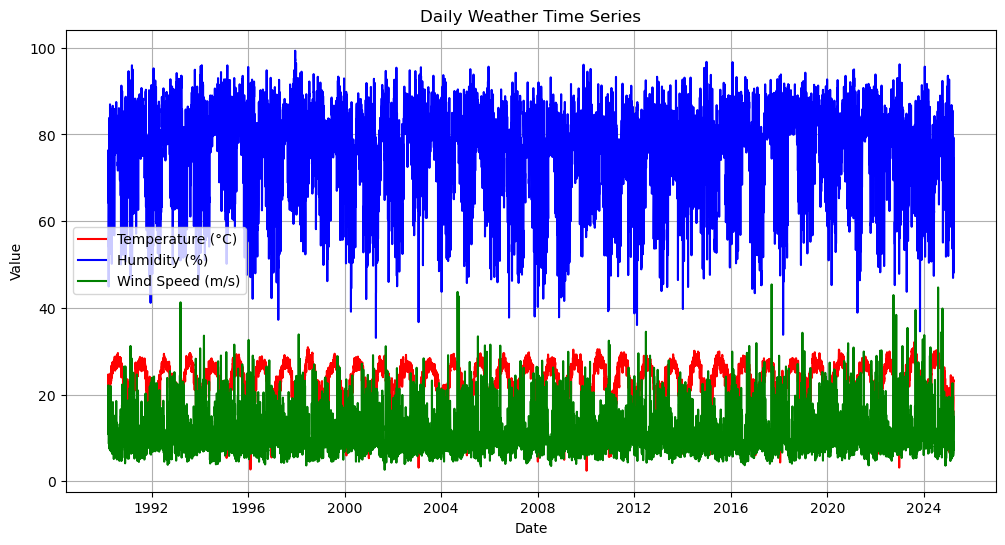

<bound method NDFrame.head of         temperature   humidity  wind_speed  precipitation  pressure_msl  \
0         23.698000  64.050011   13.684735            0.0   1018.900024   
1         22.497999  70.642754   12.599998            0.0   1019.200012   
2         21.798000  74.659874    9.290511            0.0   1019.400024   
3         21.048000  80.678024    4.680000            0.0   1019.900024   
4         20.598000  74.936317   11.183201            0.0   1019.599976   
...             ...        ...         ...            ...           ...   
307171    28.767500  29.186150   21.016878            0.0   1022.099976   
307172    29.917501  23.597696   19.121557            0.0   1020.700012   
307173    28.067501  29.990946   24.798225            0.0   1020.299988   
307174    28.067501  28.313070   20.696871            0.0   1020.099976   
307175    25.767500  36.843239   24.801491            0.0   1020.500000   

        surface_pressure  
0            1017.728149  
1            10

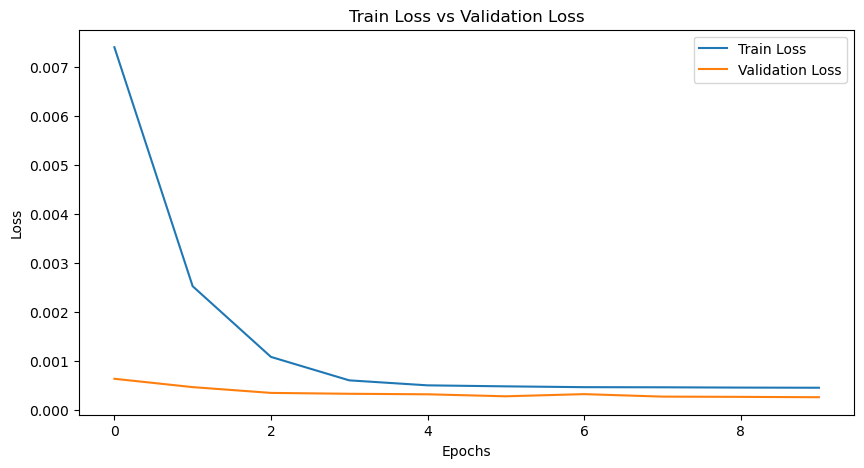

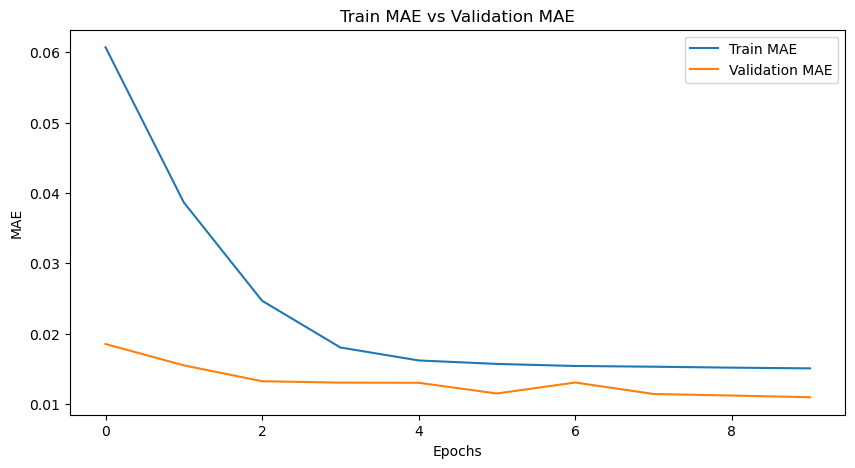

✅ Final model saved: saved_models\multihead_cnn_final.pth
Test MSE: 0.4901
First 10 Actual Values:  [24.867500195636193, 26.817502135800098, 31.76749997246335, 14.767500188437069, 25.517501610264052, 20.31750181183952, 19.66750270093133, 24.317500947944648, 28.517499810483063, 23.117500285625244]
First 10 Predicted Values:  [24.996040841782044, 28.05420105238234, 33.54309881539135, 15.389308681805128, 26.11084764717151, 20.285106905910833, 20.11068998635694, 24.373269393594033, 27.70844037530761, 22.82121198835556]


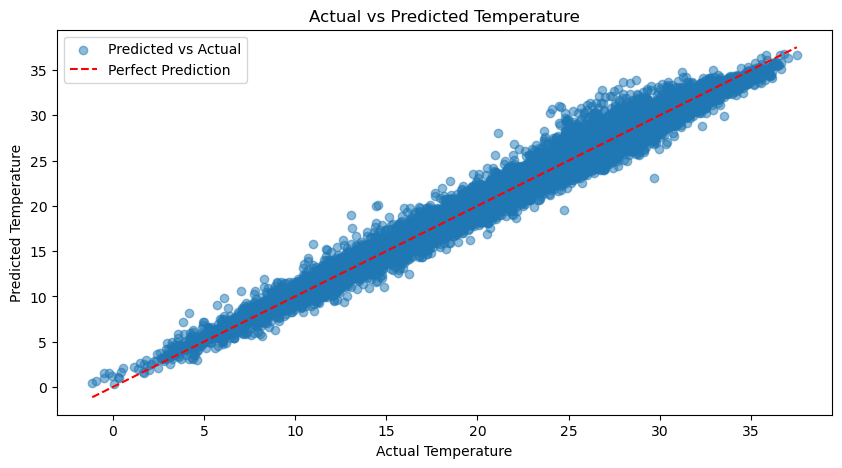

Train Loss,█▃▂▁▁▁▁▁▁▁
Train MAE,█▅▂▁▁▁▁▁▁▁
Validation Loss,█▅▃▂▂▁▂▁▁▁
Validation MAE,█▅▃▃▃▁▃▁▁▁
Best Validation Loss,0.00025
Best Validation MAE,0.01096
Train Loss,0.00045
Train MAE,0.01506
Validation Loss,0.00025
Validation MAE,0.01096


In [11]:
if __name__ == "__main__":

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Create a folder for saving models if it doesn't exist
    save_dir = "saved_models"
    os.makedirs(save_dir, exist_ok=True)

    data = fetch_weather_data()
    # Fetch weather data
    df1 = fetch_weather_data()

    # Convert 'date' column to datetime if not already
    df1["date"] = pd.to_datetime(df1["date"])

    # Resample to daily frequency, taking the mean for each day
    daily_data = df1.resample('D', on='date').mean()

    # Plot the time series
    plt.figure(figsize=(12, 6))
    plt.plot(daily_data.index, daily_data["temperature"], label="Temperature (°C)", color="red")
    plt.plot(daily_data.index, daily_data["humidity"], label="Humidity (%)", color="blue")
    plt.plot(daily_data.index, daily_data["wind_speed"], label="Wind Speed (m/s)", color="green")

    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.title("Daily Weather Time Series")
    plt.legend()
    plt.grid(True)
    plt.show()
    X_train, y_train, X_val, y_val, X_test, y_test, scaler = process_data(data)
    print(X_train.shape, y_train.shape)
    print(X_train[:2])  
    print(y_train[:2])  

    # Prepare data loaders
    train_loader = prepare_dataloader(X_train, y_train, config.batch_size)
    val_loader = prepare_dataloader(X_val, y_val, config.batch_size)
    test_loader = prepare_dataloader(X_test, y_test, config.batch_size)

    # Initialize model, loss function, and optimizer
    model = CNN().to(device)  # Move model to correct device
    criterion = nn.MSELoss()  # MSE Loss
    #criterion = nn.L1Loss()  # MAE Loss
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)

    # Train the model
    model = train_model(model, train_loader, val_loader, criterion, optimizer, config.epochs, save_dir, device)

    # Save final model
    final_model_path = os.path.join(save_dir, "multihead_cnn_final.pth")
    torch.save(model.state_dict(), final_model_path)
    wandb.save(final_model_path)
    print(f"✅ Final model saved: {final_model_path}")

    # Evaluate the model on test data
    evaluate_model(model, test_loader, scaler,device)

    # Finish wandb logging
    wandb.finish()